In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.insert(0, '/project/vitelli/jonathan/REDO_fruitfly/src')

Data shapes
Sqh:  (50, 236, 200, 2, 2)
Cad:  (50, 236, 200)
Vel:  (50, 236, 200, 2)
Coordinates shapes
XX:  (50, 236, 200) Range [3.22966, 455.701] um
YY:  (50, 236, 200) Range [3.22657, 536.891] um
TT:  (50, 236, 200) Range [-10, 39] min


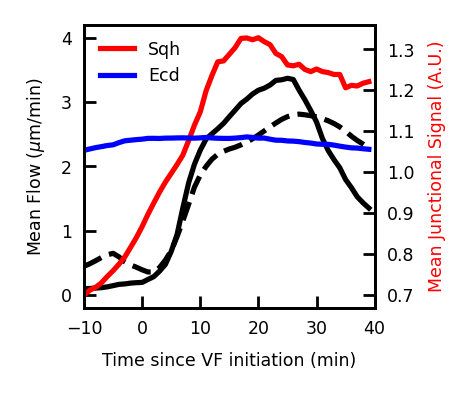

In [45]:
plt.rcParams['font.size'] = 5

loaddir = '../Public/WT/ECad-GFP/ensemble/'
cad = np.load(os.path.join(loaddir, 'raw2D.npy'), mmap_mode='r')
cad_vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')

loaddir = '../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/'
sqh = np.load(os.path.join(loaddir, 'tensor2D.npy'), mmap_mode='r')
vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')
t = np.load(os.path.join(loaddir, 't.npy'), mmap_mode='r')
y = np.load(os.path.join(loaddir, 'DV_coordinates.npy'), mmap_mode='r')
x = np.load(os.path.join(loaddir, 'AP_coordinates.npy'), mmap_mode='r')
              
    
sqh = sqh * 1e1
cad = cad
    
fig, ax = plt.subplots(1, 1, dpi=250, figsize=(1.5, 1.5))
ax2 = ax.twinx()
ax.plot(t, np.linalg.norm(vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax.plot(t, np.linalg.norm(cad_vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel', linestyle='--')
ax2.plot(t, np.linalg.norm(sqh, axis=(1, 2)).mean(axis=(1, 2)), 
         color='red', label='Sqh')
ax2.plot(t, cad.mean(axis=(1, 2)), 
         color='blue', label='Ecd')
ax2.legend(framealpha=0)

ax.set_ylim([-0.2, 4.2])
ax.set_xlim([-10, 40])
#ax2.set_yticks([80, 100, 120])
ax.set_yticks([0, 1, 2, 3, 4])

ax.set_ylabel('Mean Flow ($\\mu$m/min)')
ax2.set_ylabel('Mean Junctional Signal (A.U.)', color='red')
ax.set_xlabel('Time since VF initiation (min)')

print('Data shapes')

sqh = sqh.transpose(0, 3, 4, 1, 2)
cad = cad.transpose(0, 1, 2)

from scipy.ndimage import gaussian_filter
from atlas_processing.anisotropy_detection import cell_size
cad = gaussian_filter(cad, sigma=(0, 8, 8))
cad = 0.5 * (cad + cad[:, ::-1])

vel = vel.transpose(0, 2, 3, 1)

print('Sqh: ', sqh.shape)
print('Cad: ', cad.shape)
print('Vel: ', vel.shape)

nAP = x.shape[1]
nDV = y.shape[0]
nTP = t.shape[0]

XX = np.broadcast_to(x[None], (nTP, nDV, nAP))
YY = np.broadcast_to(y[None], (nTP, nDV, nAP))
TT = np.broadcast_to(t[:, None, None], (nTP, nDV, nAP))

print('Coordinates shapes')
print('XX: ', XX.shape, 'Range [%g, %g] um' % (XX.min(), XX.max()))
print('YY: ', YY.shape, 'Range [%g, %g] um' % (YY.min(), YY.max()))
print('TT: ', TT.shape, 'Range [%g, %g] min' % (TT.min(), TT.max()))

lower_bound = np.array([TT.min(), YY.min(), XX.min()])
upper_bound = np.array([TT.max(), YY.max(), XX.max()])

t = TT.flatten()[:, None]
y = YY.flatten()[:, None]
x = XX.flatten()[:, None]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tm = torch.from_numpy(t).float().to(device)
ym = torch.from_numpy(y).float().to(device)
xm = torch.from_numpy(x).float().to(device)

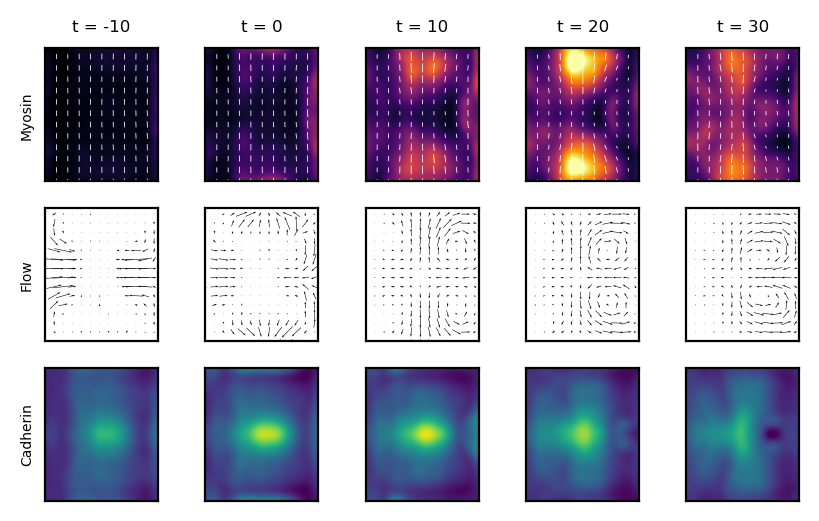

In [41]:
def plot(m1, v1, c1, times=t[::(nAP*nDV)], N=5):
    fig, ax = plt.subplots(3, N, dpi=200, figsize=(N,3))
    dt = min(10, m1.shape[0] // N)
    for i in range(N):
        ax[0, i].set_title('t = %d'% times[i*dt])
        plot_tensor2D(ax[0, i], m1[i*dt], vmin=0.06, vmax=0.25, cmap='inferno')
        plot_vector2D(ax[1, i], v1[i*dt], skip=16)
        color_2D(ax[2, i], c1[i*dt], cmap='viridis', vmin=0.8, vmax=1.8)

        for j in range(3):
            ax[j, i].set_ylim([dv_min, dv_max])


    ax[0, 0].set_ylabel('Myosin')
    ax[1, 0].set_ylabel('Flow')
    ax[2, 0].set_ylabel('Cadherin')
    
plot(sqh.transpose(0, 3, 4, 1, 2).reshape([-1, 4, 236, 200]) / 1e1,
     vel.transpose(0, 3, 1, 2),
     cad)

MSE Loss: 1.117171e-02	Phys Loss: 4.245520e-04
	D_t m = 0.0174 (1 - 0.0334 c) m + 0.0301 (1 - -0.000715 c) m Tr(E) + 0.0652 (1 - -0.00877 c) m Tr(m) + -0.00806 (1 - 0.0531 c) Gamma^DV Tr(m)


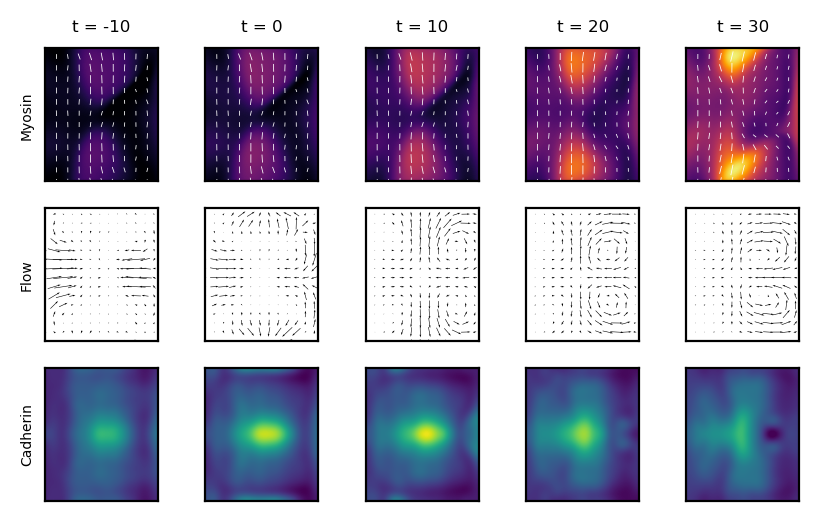

In [42]:
from utils.plot_utils import *
from run_MyosinDynamicsPINN import *
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyosinDynamicsPINN(
    t_train, y_train, x_train,
    sqh_train/1e1, cad_train, vel_train,
    lower_bound, upper_bound)
model.to(device)

dirs = './version_6_10_2023/'
beta=1e1
info = torch.load(os.path.join(dirs, f'{model.__class__.__name__}_beta={beta:.0e}.ckpt'), 
    map_location='cpu')
model.load_state_dict(info['state_dict'])
print(f"MSE Loss: {info['mse_loss']:e}\tPhys Loss: {info['phys_loss']:e}")

with torch.no_grad():
    model.print()
    m1, v1 = model(tm, ym, xm)
    m1 = m1.cpu().numpy().reshape([nTP, nDV, nAP, 2, 2]).transpose(0, 3, 4, 1, 2)
    v1 = v1.cpu().numpy().reshape([nTP, nDV, nAP, 2]).transpose(0, 3, 1, 2)
    c1 = cad

plot(m1, v1, c1)

MSE Loss: 5.406209e-04	Phys Loss: 2.669504e-01
	D_t m = -0.01 (1 - 3.08 c) m + -0.00904 (1 - 15.9 c) m Tr(E) + 0.0148 (1 - 6.96 c) m Tr(m) + 0.0155 (1 - 0.764 c) Gamma^DV Tr(m)


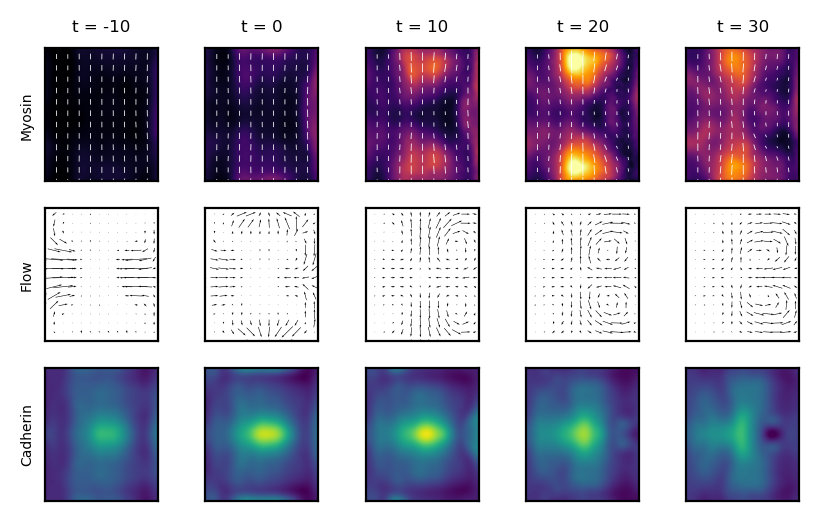

In [55]:
from utils.plot_utils import *
from run_MyosinDynamicsPINN import *
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = PositiveCoefficientsPINN(
    t_train, y_train, x_train,
    sqh_train/1e1, cad_train, vel_train,
    lower_bound, upper_bound)
model.to(device)

dirs = './version_6_10_2023/'
beta=1e-3
info = torch.load(os.path.join(dirs, f'{model.__class__.__name__}_beta={beta:.0e}.ckpt'), 
    map_location='cpu')
model.load_state_dict(info['state_dict'])
print(f"MSE Loss: {info['mse_loss']:e}\tPhys Loss: {info['phys_loss']:e}")

with torch.no_grad():
    model.print()
    m1, v1 = model(tm, ym, xm)
    times = t.reshape([nTP, nDV, nAP])[..., 0, 0]
    m1 = m1.cpu().numpy().reshape([nTP, nDV, nAP, 2, 2]).transpose(0, 3, 4, 1, 2)
    v1 = v1.cpu().numpy().reshape([nTP, nDV, nAP, 2]).transpose(0, 3, 1, 2)
    c1 = cad

plot(m1, v1, c1)

Allowed cadherin range:  0.7256937253427256 1.7891901612497598
MSE Loss: 3.502348e-04	Phys Loss: 4.374179e-04
	D_t m = 0.0293 (1 - 0.522 c) m + 0.642 (1 - 1 c) m Tr(E) + -0.0311 (1 - 0.00673 c) m Tr(m) + 0.0106 (1 - 0.998 c) Gamma^DV Tr(m)


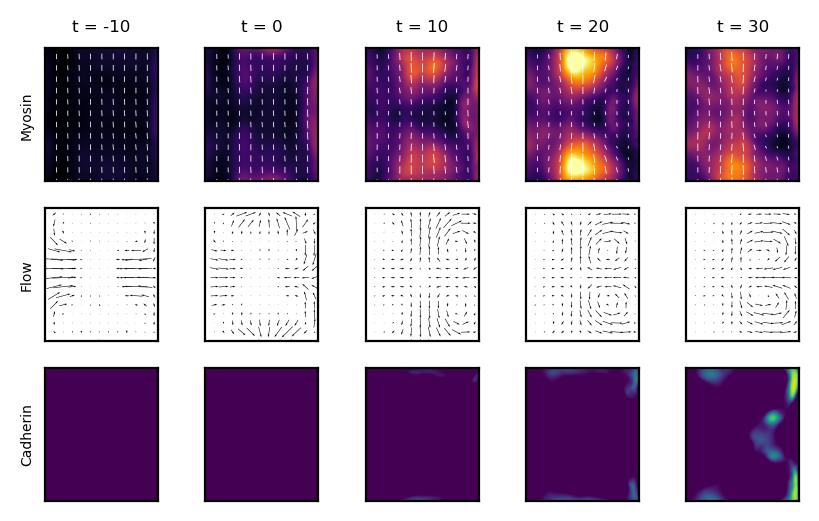

In [44]:
from utils.plot_utils import *
from run_MyosinDynamicsPINN import *
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = DorsalSourcePINN(
    t_train, y_train, x_train,
    sqh_train/1e1, cad_train, vel_train,
    lower_bound, upper_bound)
model.to(device)

dirs = './version_6_10_2023/'
beta=1e-1
info = torch.load(os.path.join(dirs, f'{model.__class__.__name__}_beta={beta:.0e}.ckpt'), 
    map_location='cpu')
model.load_state_dict(info['state_dict'])
print(f"MSE Loss: {info['mse_loss']:e}\tPhys Loss: {info['phys_loss']:e}")

with torch.no_grad():
    model.print()
    m1, v1, c1 = model(tm, ym, xm)
    times = t.reshape([nTP, nDV, nAP])[..., 0, 0]
    m1 = m1.cpu().numpy().reshape([nTP, nDV, nAP, 2, 2]).transpose(0, 3, 4, 1, 2)
    v1 = v1.cpu().numpy().reshape([nTP, nDV, nAP, 2]).transpose(0, 3, 1, 2)
    c1 = c1.cpu().numpy().reshape([nTP, nDV, nAP])

plot(m1, v1, c1)

Allowed cadherin range:  0.7256937253427256 1.7891901612497598
MSE Loss: 4.651523e-03	Phys Loss: 9.650923e-04
	D_t m = -0.301 (1 - 0.0216 c - 1.17 d) m + 0.103 (1 - 0.0389 c - 1.17 d) m Tr(E) + 0.00731 (1 - 1.16 c - 1.17 d) m Tr(m) + 0.01 (1 - 0.449 c - 1.17 d) Gamma^DV Tr(m)


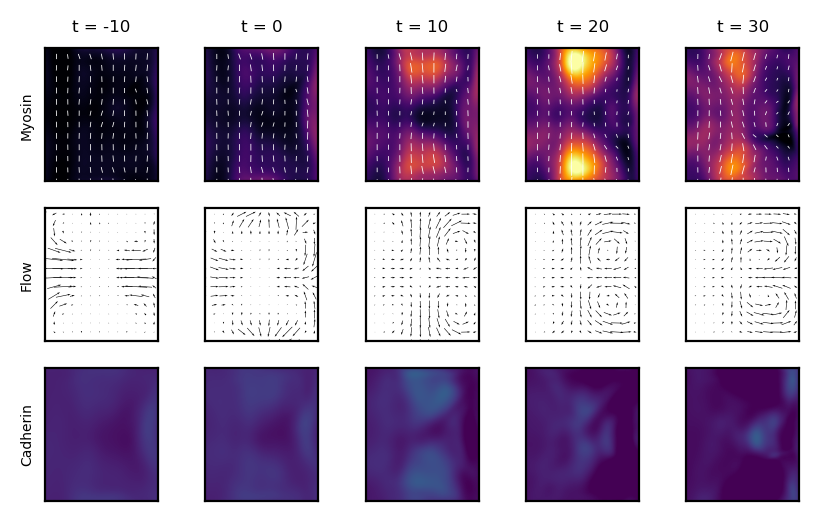

In [52]:
from utils.plot_utils import *
from run_MyosinDynamicsPINN import *
from myosin_dynamics_pinn import *
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CadherinPlusSourcePINN(
    t_train, y_train, x_train,
    sqh_train/1e1, cad_train, vel_train,
    lower_bound, upper_bound)
model.to(device)

dirs = './'
beta=1e0
info = torch.load(os.path.join(dirs, f'{model.__class__.__name__}_beta={beta:.0e}.ckpt'), 
    map_location='cpu')
model.load_state_dict(info['state_dict'])
print(f"MSE Loss: {info['mse_loss']:e}\tPhys Loss: {info['phys_loss']:e}")

with torch.no_grad():
    model.print()
    m1, v1, c1 = model(tm, ym, xm)
    times = t.reshape([nTP, nDV, nAP])[..., 0, 0]
    m1 = m1.cpu().numpy().reshape([nTP, nDV, nAP, 2, 2]).transpose(0, 3, 4, 1, 2)
    v1 = v1.cpu().numpy().reshape([nTP, nDV, nAP, 2]).transpose(0, 3, 1, 2)
    c1 = c1.cpu().numpy().reshape([nTP, nDV, nAP])

plot(m1, v1, c1)